In [1]:
# Importing the libraries
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from gensim.test.utils import datapath
from gensim.models import Word2Vec
import os
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
import seaborn as sns

# Helpful variables
EXT_DATA_FOLDER = "C:\\Users\\Admin\\Projects\\thesis\\data\\"
IMAGE_FOLDER = "C:\\Users\\Admin\\OneDrive - Macquarie University\\Uni\\2018 Semester 2\\ENGG411\\Honours-Thesis\\Thesis\\images"
EXT_DATA_FOLDER2 = "B:\\Datasets\\"
CSV_FILES = ["url_text.csv", "url_text_part2.csv"]
ACCESS_DATE = "October_4"
ANALYSIS_SAMPLES = os.path.join(EXT_DATA_FOLDER, "Credibility_Analysis_Samples\\" + ACCESS_DATE + "\\")
dataset_columns = ['Identifier', 'Type', 'Category', 'URL', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5',
 'Cat6', 'Cat7', 'Score', 'First date_time', 'Tweets', 'Likes', 'Retweets',
 'Potential exposure', 'HTML', 'TEXT']
criterias = ["Cat1", "Cat2", "Cat3", "Cat4", "Cat5", "Cat6", "Cat7"]


C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# nltk.download('punkt') #uncomment if running on new machine

In [61]:
#editing url_text_part2

csv_file = pd.read_csv("C:\\Users\\Admin\\Projects\\thesis\\data\\url_text_files\\merged_url_texts.csv")


In [62]:
print("Initial #cols", len(csv_file.columns))
print("Url: ", csv_file.columns[0])

Initial #cols 4
Url:  http://vaccineinjurynews.com/2017-08-26-the-national-meningitis-association-are-a-front-for-the-vaccine-industry.html


In [9]:
def create_dataset(corpus_path, annotated_samples):
    """
    Input: 
    corpus_path: Path for a CSV file containing a list of article URLs and its article text
    annotated_samples: Path of the excel file containing articles and its associated URL along with its labels
    
    Method:
    Retrieves the article text by matching the URLs within the corpus_path and annotated_samples and creates a dataframe 
    containing the URL, article text and the article's corresponding labels.
    
    Output:
    A pandas dataframe
    """
    article_corpus = pd.read_csv(corpus_path)
    annotated_corpus = pd.read_excel((annotated_samples))
    #article_corpus.columns = ["URL", "HTML", "TEXT"]
    annotated_articles = annotated_corpus.loc[(annotated_corpus["Cat7"] == 0) | (annotated_corpus["Cat7"] == 1)]
    dataset = pd.merge(annotated_articles, article_corpus, how='left', on='URL')
    return dataset


### Importing csv of article text

In [5]:
import glob

url_text_files = glob.glob(r'C:\\Users\\Admin\\Projects\\thesis\\data\\url_text_files\\*.csv')
combine = []
for file in url_text_files:
    df = pd.read_csv(file)
    df.columns = ["URL", "HTML", "TEXT"]
    combine.append(df)
    
combined_files = pd.concat(combine, axis=0)
combined_files.to_csv("C:\\Users\\Admin\\Projects\\thesis\\data\\url_text_files\\merged_url_texts.csv")

(1116, 3)
(2232, 3)


### Creating dataset with labelled articles

In [10]:
corpus_path = os.path.join(EXT_DATA_FOLDER, "url_text_files\\merged_url_texts.csv")
excel_files = ["sample_third_adam_new.xlsx", "sample_third_amalie_new.xlsx", "sample_third_maryke_new.xlsx"]

df_files = []

for filename in excel_files:
    annotated_path = os.path.join(ANALYSIS_SAMPLES, filename)
    data = create_dataset(corpus_path, annotated_path)
    df_files.append(data)
    
dataset = pd.concat(df_files, sort = True)

print(dataset.columns.values)
print("Number of articles: ", dataset.shape[0])

#Save dataset locally
writer = pd.ExcelWriter("dataset5.xlsx")
dataset.to_excel(writer, "Sheet1")
writer.save()



['Cat1' 'Cat2' 'Cat3' 'Cat4' 'Cat5' 'Cat6' 'Cat7' 'Category'
 'First date_time' 'HTML' 'Identifier' 'Likes' 'Potential Exposure'
 'Potential exposure' 'Retweets' 'Score' 'TEXT' 'Tweets' 'Type' 'URL'
 'Unnamed: 0']
(475, 21)


C:\Users\Admin\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:832: UserWarning: Ignoring URL 'https://www.washingtonpost.com/national/health-science/anti-vaccine-activists-spark-a-states-worst-measles-outbreak-in-decades/2017/05/04/a1fac952-2f39-11e7-9dec-764dc781686f_story.html?hpid=hp_hp-more-top-stories_measles-910a%3Ahomepage%2Fstory&utm_term=.9ee4c65bed78' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\Admin\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:832: UserWarning: Ignoring URL 'https://www.change.org/p/department-of-education-secretary-of-state-justine-greening-stop-vaccination-with-the-influenza-nasal-spray-vaccine-in-our-schools/nftexp/ex5/control/21207518?recruiter=21207518&utm_source=share_petition&utm_medium=facebook&utm_campaign=autopublish&utm_term=autopublish&utm_content=ex5%3Acontrol' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(

In [15]:
corpus_path = os.path.join(EXT_DATA_FOLDER + "url_text_files\\", "merged_url_texts.csv")
text = pd.read_csv(corpus_path)

In [2]:
#pre-processing
from collections import defaultdict

labelled_articles = pd.read_excel("dataset5.xlsx")
labelled_articles = labelled_articles.dropna(subset=['TEXT'])
labelled_articles = labelled_articles[pd.to_numeric(labelled_articles['Cat1'], errors='coerce').notnull()]
labelled_articles = labelled_articles.dropna(subset=['Cat1'])

for criteria in criterias:
    labelled_articles = labelled_articles.dropna(subset=[criteria])

print(labelled_articles.shape)
art_text_sent = np.array([sent_tokenize(article.split("TITLE: ")[1].replace("TEXT: ","").strip(" ")) for article in labelled_articles["TEXT"]])
art_text_word = np.array([word_tokenize(article.split("TITLE: ")[1].replace("TEXT: ","").strip(" ")) for article in labelled_articles["TEXT"]])
art_text_sent_word = np.array([[word_tokenize(sent) for sent in article] for article in art_text_sent])
labels = [labelled_articles["Cat1"], labelled_articles["Cat2"], labelled_articles["Cat3"], labelled_articles["Cat4"], labelled_articles["Cat5"], labelled_articles["Cat6"], labelled_articles["Cat7"]]
labels = np.array(labels).transpose()
multi_labels = np.array([[int(x) for x in row] for row in labels])

(470, 21)


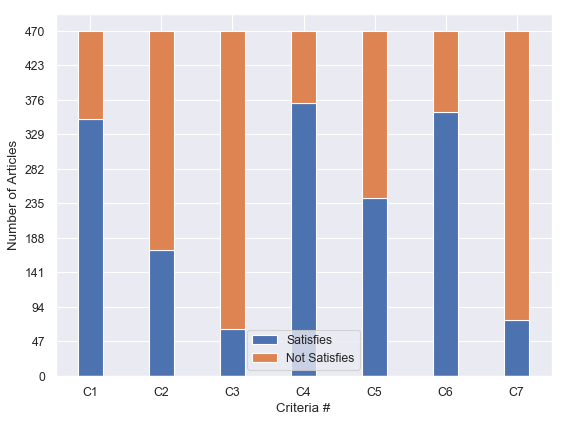

[350, 171, 64, 372, 242, 360, 76]
[120, 299, 406, 98, 228, 110, 394]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sns.set()

N = 7
num_articles = len(labelled_articles)
satisfy_count = [len(labelled_articles.loc[(labelled_articles[criteria] == 1)]) for criteria in criterias]
not_satisfy_count = [len(labelled_articles.loc[(labelled_articles[criteria] == 0)]) for criteria in criterias]
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.bar(ind, satisfy_count, width)
p2 = plt.bar(ind, not_satisfy_count, width,
             bottom=satisfy_count)
plt.ylabel('Number of Articles')
plt.xlabel('Criteria #')
plt.xticks(ind, ('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'))
plt.yticks(np.arange(0, (num_articles + 19) // 10 * 10, int(num_articles/10)))
plt.legend((p1[0], p2[0]), ('Satisfies', 'Not Satisfies'))

plt.savefig(os.path.join(IMAGE_FOLDER,'label-distribution.png'), bbox_inches='tight')
plt.show()
print(satisfy_count)
print(not_satisfy_count)

[57, 41, 75, 178, 75, 26, 18]


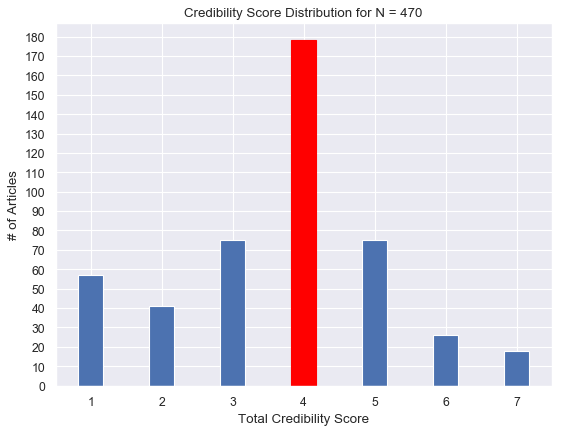

In [4]:
scores = [0, 0, 0, 0 ,0 ,0 ,0]
for article in multi_labels:
    scores[np.sum(article)-1] = scores[np.sum(article)-1] + 1
    
print(scores)

N = 7
maximum = np.amax(scores)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.bar(ind, scores, width)
p1[3].set_color('red')


plt.ylabel('# of Articles')
plt.xlabel('Total Credibility Score')
plt.title('Credibility Score Distribution for N = ' + str(num_articles))
plt.xticks(ind, ('1', '2', '3', '4', '5', '6', '7'))
plt.yticks(np.arange(0, (maximum + 19) // 10 * 10, 10))
plt.savefig(os.path.join(IMAGE_FOLDER,'article-score-distribution.png'), bbox_inches='tight')
plt.show()


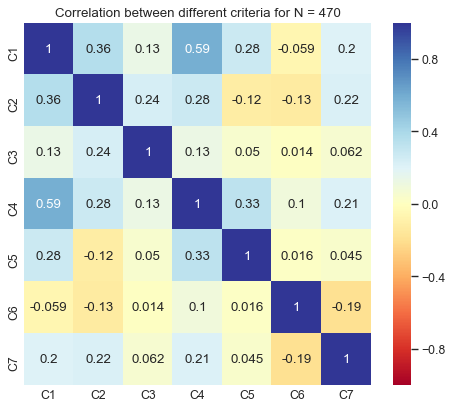

In [39]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
plt.figure(figsize = (7,6), dpi=80)
scores = labelled_articles.loc[:, 'Cat1':'Cat7'].astype(float)
scores.columns = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
coocc = np.array(scores.T.dot(scores).values.tolist())
ax = sns.heatmap(scores.corr(), annot=True, vmin=-1, vmax=1, cmap="RdYlBu")
ax.tick_params(length=0)
ax.set_title("Correlation between different criteria for N = " + str(len(labelled_articles)))
plt.savefig(os.path.join(IMAGE_FOLDER,'criteria-correlation.png'), bbox_inches='tight')
plt.show()